In [1]:
%run 0_3_configure_mlflow.ipynb

Experiment_id: 1
Artifact Location: file:///C:/Users/Piotrek/Documents/Inzynierka/csgo-analysis/mlruns/1
Tags: {}
Lifecycle_stage: active


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle
import random
import shap
import os
import shutil
import math

from sklearn.metrics import accuracy_score, precision_score, recall_score, log_loss, f1_score, roc_auc_score, RocCurveDisplay
from sklearn.calibration import CalibrationDisplay
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedKFold, train_test_split
from tensorflow.keras import Sequential
from tensorflow.keras.layers import InputLayer, GRU, Dense, Masking, Flatten
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.metrics import AUC, BinaryAccuracy
from tensorflow.keras.utils import Sequence
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, CSVLogger

# Wczytanie danych

In [3]:
def select_feat():
    columns = [
        'seconds', 'ctAlivePlayers', 'ctEqVal', 'tAlivePlayers', 'tEqVal',
       'ct_armor', 't_armor', 'ct_hp', 't_hp', 'ct_hasHelmet', 't_hasHelmet', 'ct_DecoyGrenade',
       't_DecoyGrenade', 'ct_Flashbang', 't_Flashbang', 'ct_HEGrenade',
       't_HEGrenade', 'ct_SmokeGrenade', 't_SmokeGrenade', 'ct_fireGrenades',
       't_fireGrenades', 'ct_isBlinded', 't_isBlinded', 'ct_hasDefuse',
       't_hasBomb', 'ct_isDefusing', 't_isPlanting', 'ct_spottedPlayers',
       't_spottedPlayers', 'ct_grouppedPlayers',
       'ct_meanDist', 'ct_minDist', 't_meanDist','t_minDist',
       't_grouppedPlayers', 'ct_conquerMap', 't_conquerMap', 'ct_activeWeapon_Pistol',
       'ct_activeWeapon_EnhancedPistols', 'ct_activeWeapon_Deagle',
       'ct_activeWeapon_SMG', 'ct_activeWeapon_WeakAssaultRifle',
       'ct_activeWeapon_LunetRifle', 'ct_activeWeapon_SniperRifle',
       'ct_activeWeapon_AssaultRifle', 'ct_activeWeapon_Others',
       't_activeWeapon_Pistol', 't_activeWeapon_EnhancedPistols',
       't_activeWeapon_Deagle', 't_activeWeapon_SMG',
       't_activeWeapon_WeakAssaultRifle', 't_activeWeapon_LunetRifle',
       't_activeWeapon_SniperRifle', 't_activeWeapon_AssaultRifle',
       't_activeWeapon_Others', 'ct_mainWeapon_Pistol',
       'ct_mainWeapon_EnhancedPistols', 'ct_mainWeapon_Deagle',
       'ct_mainWeapon_SMG', 'ct_mainWeapon_WeakAssaultRifle',
       'ct_mainWeapon_LunetRifle', 'ct_mainWeapon_SniperRifle',
       'ct_mainWeapon_AssaultRifle', 't_mainWeapon_Pistol', 't_mainWeapon_EnhancedPistols',
       't_mainWeapon_Deagle', 't_mainWeapon_SMG',
       't_mainWeapon_WeakAssaultRifle', 't_mainWeapon_LunetRifle',
       't_mainWeapon_SniperRifle', 't_mainWeapon_AssaultRifle', 
       'ct_secondaryWeapon_Pistol','ct_secondaryWeapon_EnhancedPistols', 'ct_secondaryWeapon_Deagle',
       't_secondaryWeapon_Pistol', 't_secondaryWeapon_EnhancedPistols',
       't_secondaryWeapon_Deagle', 'ctMinDistToA',
       'ctMinDistToB', 'tMinDistToA', 'tMinDistToB', 'ctMeanDistToA',
       'ctMeanDistToB', 'tMeanDistToA', 'tMeanDistToB', 'ctMeanKills',
       'tMeanKills', 'tScore', 'ctScore', 'de_ancient', 
       'de_dust2', 'de_inferno', 'de_mirage', 'de_nuke', 'de_overpass',
       'de_vertigo','bombsite_A', 'bombsite_B', 'bombsite_not_planted'
    ]
    return columns

In [4]:
df = pd.read_parquet('data/ESTA_states_prepared.parquet', columns=select_feat() + ['matchName', 'demoId', 'roundNum',  "winningSideCT"])
df

,seconds,ctAlivePlayers,ctEqVal,tAlivePlayers,tEqVal,ct_armor,t_armor,ct_hp,t_hp,ct_hasHelmet,...,de_nuke,de_overpass,de_vertigo,bombsite_A,bombsite_B,bombsite_not_planted,matchName,demoId,roundNum,winningSideCT
0,0.007874,5,4400,5,4250,400,300,500,500,0,...,1,0,0,0,0,1,heroic-vs-big-iem-katowice-2021,00330e8b-ba01-4d3f-a6c1-66881b879dac,1,0
1,0.511811,5,4400,5,4250,400,300,500,500,0,...,1,0,0,0,0,1,heroic-vs-big-iem-katowice-2021,00330e8b-ba01-4d3f-a6c1-66881b879dac,1,0
2,1.015748,5,4400,5,4250,400,300,500,500,0,...,1,0,0,0,0,1,heroic-vs-big-iem-katowice-2021,00330e8b-ba01-4d3f-a6c1-66881b879dac,1,0
3,1.519685,5,4400,5,4250,400,300,500,500,0,...,1,0,0,0,0,1,heroic-vs-big-iem-katowice-2021,00330e8b-ba01-4d3f-a6c1-66881b879dac,1,0
4,2.023622,5,4400,5,4250,400,300,500,500,0,...,1,0,0,0,0,1,heroic-vs-big-iem-katowice-2021,00330e8b-ba01-4d3f-a6c1-66881b879dac,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7464293,81.464567,3,26800,1,24300,290,94,233,74,3,...,0,0,1,0,0,1,spirit-vs-copenhagen-flames-pgl-major-antwerp-...,ff910f54-0bed-4fdf-afa8-b481be09a788,26,1
7464294,81.968504,3,26800,1,24300,290,94,233,74,3,...,0,0,1,0,0,1,spirit-vs-copenhagen-flames-pgl-major-antwerp-...,ff910f54-0bed-4fdf-afa8-b481be09a788,26,1
7464295,82.472441,3,26800,1,24300,286,94,206,74,3,...,0,0,1,0,0,1,spirit-vs-copenhagen-flames-pgl-major-antwerp-...,ff910f54-0bed-4fdf-afa8-b481be09a788,26,1
7464296,82.976378,2,26800,1,24300,194,94,159,74,2,...,0,0,1,0,0,1,spirit-vs-copenhagen-flames-pgl-major-antwerp-...,ff910f54-0bed-4fdf-afa8-b481be09a788,26,1


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7464298 entries, 0 to 7464297
Columns: 103 entries, seconds to winningSideCT
dtypes: float64(17), int32(7), int64(67), object(2), uint8(10)
memory usage: 5.1+ GB


## Podział

In [6]:
filtr = ~df.matchName.str.endswith("iem-katowice-2022")
df = df[filtr].reset_index(drop=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7137130 entries, 0 to 7137129
Columns: 103 entries, seconds to winningSideCT
dtypes: float64(17), int32(7), int64(67), object(2), uint8(10)
memory usage: 4.8+ GB


In [7]:
groupped = df.groupby(['demoId', 'roundNum'])
demo_indexes = list(groupped.indices.keys())
demo_round = pd.DataFrame.from_records(demo_indexes, columns=['demoId', 'roundNum'])
demo_round

,demoId,roundNum
0,0013db25-4444-452b-980b-7702dc6fb810,1
1,0013db25-4444-452b-980b-7702dc6fb810,2
2,0013db25-4444-452b-980b-7702dc6fb810,3
3,0013db25-4444-452b-980b-7702dc6fb810,4
4,0013db25-4444-452b-980b-7702dc6fb810,5
...,...,...
39328,ff910f54-0bed-4fdf-afa8-b481be09a788,22
39329,ff910f54-0bed-4fdf-afa8-b481be09a788,23
39330,ff910f54-0bed-4fdf-afa8-b481be09a788,24
39331,ff910f54-0bed-4fdf-afa8-b481be09a788,25


In [8]:
demo_round_train, demo_round_val = train_test_split(demo_round, test_size=0.2, random_state=1)
demo_round_train.shape, demo_round_val.shape

((31466, 2), (7867, 2))

In [9]:
df_train = df.merge(demo_round_train, on=['demoId', 'roundNum'])
df_val = df.merge(demo_round_val, on=['demoId', 'roundNum'])
df_train.shape, df_val.shape

((5704213, 103), (1432917, 103))

In [10]:
df_test = pd.read_parquet('data/states_another_mod_test.parquet', columns=select_feat() + [ "winningSideCT", 'matchID', "filename", 'roundNum'])
df_test.rename(columns={"matchID": "demoId"}, inplace=True)
past = df_test['filename'].str.startswith("IEM-Katowice")
future = df_test['filename'].str.startswith("BLAST-Premier-Spring-Final-2022")
df_test.shape

(620392, 103)

In [11]:
def generate_indices(data, lookback, step=1):
    grouped = data.groupby(['demoId', 'roundNum'])
    dict_gr = grouped.indices
    for key, val in dict_gr.items():
        dict_gr[key] = np.min(val),  np.max(val)
    
    indices = np.zeros((len(data.index), lookback), dtype=np.int32)
    for key in dict_gr:
        minimum, maximum = dict_gr[key]
        for i in range(minimum, maximum + 1):
            if i - minimum < lookback:
                indices[i] = np.hstack((np.repeat(-1, lookback - ((i + 1 - minimum) / step)), np.arange(minimum, i + 1, step, dtype=np.int32)))
            else:
                indices[i] = np.arange(i - step * (lookback - 1), i + 1, step, dtype=np.int32)
    return indices

In [12]:
lookback = 20
train_indexes = generate_indices(df_train, lookback)
valid_indexes = generate_indices(df_val, lookback)
test_indexes = generate_indices(df_test, lookback, step=2)
train_indexes.size * train_indexes.itemsize / 1_000_000, valid_indexes.size * valid_indexes.itemsize / 1_000_000 , test_indexes.size * test_indexes.itemsize / 1_000_000

(456.33704, 114.63336, 49.63136)

In [13]:
test_indexes

array([[    -1,     -1,     -1, ...,     -1,     -1,      0],
       [    -1,     -1,     -1, ...,     -1,     -1,      0],
       [    -1,     -1,     -1, ...,     -1,      0,      2],
       ...,
       [620351, 620353, 620355, ..., 620385, 620387, 620389],
       [620352, 620354, 620356, ..., 620386, 620388, 620390],
       [620353, 620355, 620357, ..., 620387, 620389, 620391]])

In [14]:
y_train, y_valid, y_test = df_train['winningSideCT'], df_val['winningSideCT'], df_test['winningSideCT']
norm_train = df_train.drop(['matchName', 'demoId', 'roundNum', 'winningSideCT'], axis='columns')
norm_valid = df_val.drop(['matchName', 'demoId', 'roundNum', 'winningSideCT'], axis='columns')
norm_test = df_test.drop(["filename", 'demoId', 'roundNum', 'winningSideCT'], axis='columns')
cols = norm_train.columns.tolist()
del df_train, df_val, df_test
scaler = StandardScaler()
norm_train = scaler.fit_transform(norm_train)
norm_valid = scaler.transform(norm_valid)
norm_test = scaler.transform(norm_test)

In [15]:
class CSGOsequence(Sequence):
    def __init__(self, x_set, y_set, batch_size, indices, shuffle):
        self.x, self.y = x_set, y_set
        self.indices = indices
        self.batch_size = batch_size
        self.shuffle = shuffle
        if self.shuffle:
            np.random.shuffle(self.indices)

    def __len__(self):
        return math.ceil(self.indices.shape[0] / self.batch_size)
                         
    def __getitem__(self, idx):
        batch_x = [np.array([np.zeros(self.x.shape[-1]) if val < 0 else self.x[val] 
                   for val in index])
                       for index in self.indices[idx * self.batch_size : (idx + 1) * self.batch_size]]
        batch_y = self.y[self.indices[idx * self.batch_size : (idx + 1) * self.batch_size, -1]]
        return np.array(batch_x), np.array(batch_y)
    
    def on_epoch_end(self):
        if self.shuffle:
            np.random.shuffle(self.indices)

In [16]:
train_seq = CSGOsequence(norm_train, y_train.values, 10000, train_indexes, shuffle=True)
valid_seq = CSGOsequence(norm_valid, y_valid.values, 10000, valid_indexes, shuffle=False)
test_seq = CSGOsequence(norm_test, y_test.values, 10000, test_indexes, shuffle=False)

In [17]:
os.makedirs("model_deep", exist_ok=True)

In [18]:
early_stopping = EarlyStopping(
    monitor='val_loss',
    min_delta=0.0001,
    patience=10,
    verbose=0,
    mode='min',
    baseline=None,
    restore_best_weights=True,
)

model_checkpoint_callback = ModelCheckpoint(
    filepath="model_deep/rnn.tf",
    monitor='val_loss',
    mode='min',
    save_best_only=True)

logger = CSVLogger(
    "model_deep/rnn_log.csv", separator=',', append=True
)

In [19]:
model = Sequential()
model.add(InputLayer(input_shape=(lookback, norm_train.shape[-1])))
model.add(Masking(mask_value=0.))
model.add(GRU(256, kernel_regularizer='l2', recurrent_regularizer='l2', bias_regularizer='l2', activity_regularizer='l2', dropout=0.2))
model.add(Dense(128, activation='relu', kernel_regularizer='l2', bias_regularizer='l2', activity_regularizer='l2'))
model.add(Dense(1, activation='sigmoid', kernel_regularizer='l2', bias_regularizer='l2', activity_regularizer='l2'))

model.compile(optimizer="Adam", loss=BinaryCrossentropy(), metrics=[BinaryAccuracy(), AUC()])
history = model.fit(train_seq,
                    epochs=200,
                    validation_data=valid_seq,
                    callbacks=[early_stopping, model_checkpoint_callback, logger])

Epoch 1/200
571/571 [==============================] - 205s 352ms/step - loss: 0.8638 - binary_accuracy: 0.7558 - auc: 0.8544 - val_loss: 0.5427 - val_binary_accuracy: 0.7674 - val_auc: 0.8648


INFO:tensorflow:Assets written to: model_deep\rnn.tf\assets


INFO:tensorflow:Assets written to: model_deep\rnn.tf\assets


Epoch 2/200
571/571 [==============================] - 202s 353ms/step - loss: 0.5516 - binary_accuracy: 0.7570 - auc: 0.8562 - val_loss: 0.5424 - val_binary_accuracy: 0.7666 - val_auc: 0.8645


INFO:tensorflow:Assets written to: model_deep\rnn.tf\assets


INFO:tensorflow:Assets written to: model_deep\rnn.tf\assets


Epoch 3/200
571/571 [==============================] - 201s 352ms/step - loss: 0.5513 - binary_accuracy: 0.7573 - auc: 0.8564 - val_loss: 0.5423 - val_binary_accuracy: 0.7671 - val_auc: 0.8651


INFO:tensorflow:Assets written to: model_deep\rnn.tf\assets


INFO:tensorflow:Assets written to: model_deep\rnn.tf\assets


Epoch 4/200
571/571 [==============================] - 201s 351ms/step - loss: 0.5513 - binary_accuracy: 0.7573 - auc: 0.8564 - val_loss: 0.5426 - val_binary_accuracy: 0.7666 - val_auc: 0.8648
Epoch 5/200
571/571 [==============================] - 203s 355ms/step - loss: 0.5513 - binary_accuracy: 0.7572 - auc: 0.8564 - val_loss: 0.5420 - val_binary_accuracy: 0.7676 - val_auc: 0.8649


INFO:tensorflow:Assets written to: model_deep\rnn.tf\assets


INFO:tensorflow:Assets written to: model_deep\rnn.tf\assets


Epoch 6/200
571/571 [==============================] - 201s 351ms/step - loss: 0.5514 - binary_accuracy: 0.7573 - auc: 0.8565 - val_loss: 0.5424 - val_binary_accuracy: 0.7670 - val_auc: 0.8647
Epoch 7/200
571/571 [==============================] - 202s 353ms/step - loss: 0.5513 - binary_accuracy: 0.7572 - auc: 0.8565 - val_loss: 0.5422 - val_binary_accuracy: 0.7676 - val_auc: 0.8649
Epoch 8/200
571/571 [==============================] - 202s 353ms/step - loss: 0.5515 - binary_accuracy: 0.7572 - auc: 0.8564 - val_loss: 0.5421 - val_binary_accuracy: 0.7674 - val_auc: 0.8650
Epoch 9/200
571/571 [==============================] - 203s 354ms/step - loss: 0.5514 - binary_accuracy: 0.7574 - auc: 0.8565 - val_loss: 0.5421 - val_binary_accuracy: 0.7676 - val_auc: 0.8651
Epoch 10/200
571/571 [==============================] - 202s 353ms/step - loss: 0.5515 - binary_accuracy: 0.7571 - auc: 0.8565 - val_loss: 0.5420 - val_binary_accuracy: 0.7681 - val_auc: 0.8652
Epoch 11/200
571/571 [============

INFO:tensorflow:Assets written to: models/model.tf\assets


INFO:tensorflow:Assets written to: models/model.tf\assets


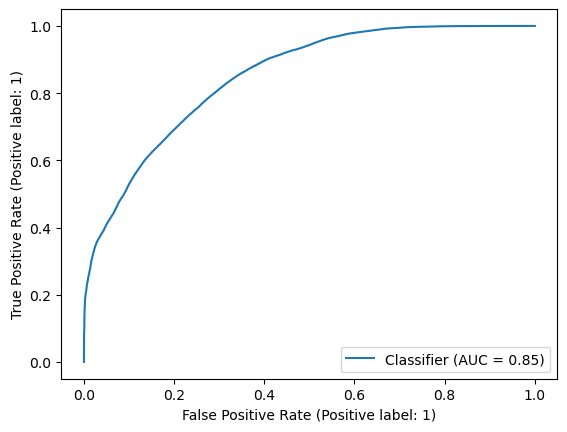

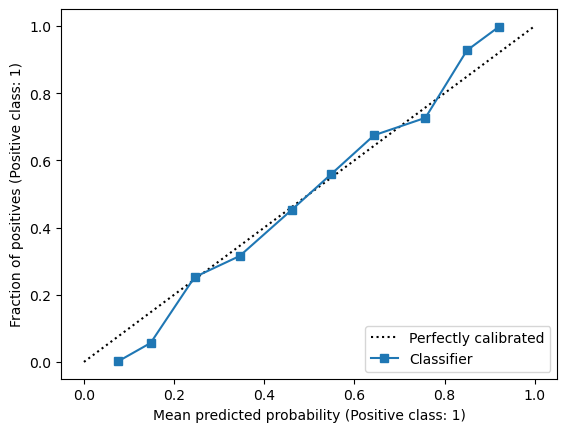

In [20]:
run_name = "RNN - ESTA My Test"
additional_description = "RNN"
with mlflow.start_run(run_name=run_name, description=additional_description) as run:
        mlflow.log_param("X_train.shape", norm_train.shape)
        mlflow.log_param("X_test.shape", norm_test.shape)
        mlflow.log_param("Sequence", lookback)

        y_proba = model.predict(test_seq)
        y_true = y_test[test_indexes[:, -1]]
        features_names = cols
        metrics = {}
        for threshold in np.arange(0.1, 1, 0.05):
            y_pred = (y_proba >= threshold).astype(int)
            metrics[f"accuracy_{threshold:.2f}"] = accuracy_score(y_true=y_true, y_pred=y_pred)
            metrics[f"precision_{threshold:.2f}"] = precision_score(y_true=y_true, y_pred=y_pred)
            metrics[f"recall_{threshold:.2f}"] = recall_score(y_true=y_true, y_pred=y_pred)
            metrics[f"f1_{threshold:.2f}"] = f1_score(y_true=y_true, y_pred=y_pred)
        metrics["roc_auc"] = roc_auc_score(y_true=y_true, y_score=y_proba)
        metrics["log_loss"] = log_loss(y_true=y_true, y_pred=y_proba)
        mlflow.log_metrics(metrics)
        
        if os.path.exists('artifacts'):
            shutil.rmtree('artifacts')
            os.makedirs('artifacts')
        
        if os.path.exists('models'):
            shutil.rmtree('models')
            os.makedirs('models')
            
        with open("artifacts/features.txt", 'w') as f:
            f.write(str(features_names))
            
        model.save('models/model.tf')
        
        with open("models/scaler.pkl", "wb") as f:
            pickle.dump(scaler, f)

        roc_plot = RocCurveDisplay.from_predictions(y_pred=y_proba, y_true=y_true)
        roc_plot.figure_.savefig('artifacts/roc_auc.png')
        plt.show()
        
        calibration_curve = CalibrationDisplay.from_predictions(y_prob=y_proba, y_true=y_true, n_bins=10)
        calibration_curve.figure_.savefig('artifacts/calibration_curve.png')
        plt.show()
        
        mlflow.log_artifacts("artifacts", artifact_path="plots_data")
        mlflow.log_artifacts("models", artifact_path="model")

In [23]:
y_proba = model.predict(test_seq)
y_true = y_test[test_indexes[:, -1]]
results = {
        "LogLoss (all)": log_loss(y_true, y_proba),
        "LogLoss (future)": log_loss(y_true[future], y_proba[future]),
        "LogLoss (past)": log_loss(y_true[past], y_proba[past]),
        "AUC-ROC (all)": roc_auc_score(y_true, y_proba),
        "AUC-ROC (future)": roc_auc_score(y_true[future], y_proba[future]),
        "AUC-ROC (past)": roc_auc_score(y_true[past], y_proba[past])
}
results

{'LogLoss (all)': 0.4835447229256168,
 'LogLoss (future)': 0.48266399362571766,
 'LogLoss (past)': 0.48436594886452833,
 'AUC-ROC (all)': 0.8494164039223757,
 'AUC-ROC (future)': 0.8530926507056478,
 'AUC-ROC (past)': 0.8452711556390315}